### Import the libs and data sets

In [22]:
!pip install minisom

In [23]:
from minisom import MiniSom

In [24]:
import numpy as np
import pandas as pd

In [25]:
dataset = pd.read_csv('/Users/kyotun/Desktop/ML/fraud-detection/csv/credit_card_applications.csv')
dataset

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.58,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.17,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.25,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.00,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.96,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,15808223,1,31.57,10.50,2,14,4,6.50,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.41,2,8,4,0.12,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.54,2,6,4,0.09,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.50,2,14,8,3.08,1,1,1,0,2,120,12,1


In [26]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

### Feature Scaling

In [27]:
from sklearn.preprocessing import MinMaxScaler

In [28]:
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)
pd.set_option('display.float_format', '{:.2f}'.format)
np.set_printoptions(precision=10)
X

array([[8.4268146671e-01, 1.0000000000e+00, 1.2526315789e-01, ...,
        5.0000000000e-01, 5.0000000000e-02, 1.2120000000e-02],
       [6.9609056217e-01, 0.0000000000e+00, 1.3413533835e-01, ...,
        5.0000000000e-01, 8.0000000000e-02, 0.0000000000e+00],
       [3.8898165612e-01, 0.0000000000e+00, 2.3804511278e-01, ...,
        5.0000000000e-01, 1.4000000000e-01, 0.0000000000e+00],
       ...,
       [4.3942033164e-01, 0.0000000000e+00, 7.6390977444e-02, ...,
        5.0000000000e-01, 5.0000000000e-02, 0.0000000000e+00],
       [8.4403493387e-01, 0.0000000000e+00, 2.0556390977e-01, ...,
        5.0000000000e-01, 6.0000000000e-02, 1.1000000000e-04],
       [1.0690788815e-01, 1.0000000000e+00, 4.0977443609e-01, ...,
        0.0000000000e+00, 2.8000000000e-01, 0.0000000000e+00]])

### Create and train the model

In [29]:
# x,y -> dimensions of map, choose is arbitrary
# it cannot be too small, cause we cannot observe outliers
# input len -> number of features
# we keep the customerIDs, so input len -> 15
# x,y = 10,10 -> arbitrary
# learning rate -> speed of convergence, lower is longer but more accurate
# decay_func -> can be used to improve convergence
# random seed -> initialize the random number generator
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)

# initialize the weights to small numbers close to 0
som.random_weights_init(X)

# select one random observation point from the dataset
# compute the Euclidean distances from this point to the different neurons in the network
# Select the neuron that has the min dist to the point. This neuron is winning node
# Update the weights of the winning node to move it closer to the point
# Gaussian neighbourhood func of mean the winning node, update the weights of the winning node nieghbours to move them closer to the point
#          the neighbourhood raidus is sigma in the gaussian func
# repeat these above steps (1 iteration)
som.train_random(data = X, num_iteration = 100)

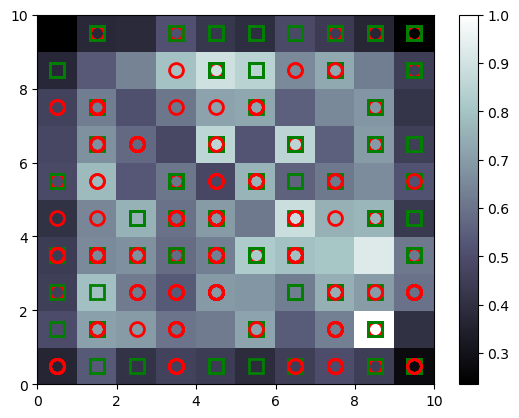

In [30]:
# MID -> mean interneuron distance
# the higher the MID the more the winning node is an outlier
# larger the MID, closer the color to white

from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
# white -> radius is larger, close to 1

# detect the customers those who has got an approval
# add some markers
markers = ['o', 's']
colors = ['r', 'g']
# loop over all customers, get winning node
# red circle if not approved
# green square if the customer is indeed approved

# i -> index
# x -> row vectors
# we color only the edge not inside of the circle/square that is why -> markeredgecolor
# if approved y=1
# if not approved y=0
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
        markeredgewidth = 2)
show()
# we observe both cases in some squares
# we'll seperate and catch them

In [31]:
mappings = som.win_map(X)
# save as dictionary, indexes are like (0,0) (5,6). These indexes show the start point of the square
# (0,0) takes the first square that goes from x -> 0,1 and y -> 0,1. It's a 1x1 square
# These squares contain customers
# We observe 100 square, each one of them contain different number of customers with their attributes

In [32]:
#fraud potentials are -> (1,6) , (4,1) these ones are totally white
# we're adding one list on top of another there fore axis = 0, adding vertically not horizontally
# values are still scaled, we inverse it and take out the IDs

frauds = np.concatenate((mappings[(1,6)], mappings[(4,1)], mappings[(4,4)], mappings[(6,8)]), axis = 0)
frauds = sc.inverse_transform(frauds)
df = pd.DataFrame(frauds, columns=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15'])
df

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [ ]:
fraud_customers = df['1']
fraud_customers

0    15610042.00
1    15627328.00
2    15687634.00
3    15715750.00
4    15701081.00
5    15690898.00
6    15640521.00
7    15725002.00
8    15662854.00
9    15745375.00
10   15638983.00
11   15734578.00
12   15795527.00
13   15800554.00
14   15617991.00
15   15696120.00
16   15689781.00
17   15735837.00
18   15799785.00
19   15649183.00
20   15593694.00
21   15785367.00
22   15781574.00
Name: 1, dtype: float64